# Análise utilizando os autovalores da matriz Laplaciana

O segundo menor autovalor da matriz Laplaciana do grafo também é chamado de conectividade algébrica e possui propriedades interessantes sobre a conectividade do grafo. Ao invés de considerar apenas o segundo menor, podemos considerar um range $[2,...]$ para uma representação de maior dimensão para cada grafo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time
import torch
import pickle
import parkinson

import numpy as np
import pandas as pd
import networkx as nx
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from joblib import Parallel, delayed
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler

In [3]:
RDN = 42
N_CLASSES = 2
BATCH_SIZE = 4
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001

### Processamento dos dados

In [13]:
# lendo os arquivos de dados
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns') 

  0%|          | 0/153 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:03<00:00, 20.94it/s]


Checando as colunas que aparecem no dataset Control para Shen_268 e renomeando

In [14]:
for i in range(len(control_data)):
    df = control_data[i]
    replace_dict = {
        column: column.replace('shen-268', 'Shen_268').replace('shen 268', 'Shen_268').replace('Shen-268', 'Shen_268')
        for column in df.columns
    }
    control_data[i] = df.rename(columns=replace_dict)

### Montagem do Grafo

In [25]:
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

In [26]:
parkinson_correlation_matrix = parkinson.utils.correlation.pearson_correlation(parkinson_atlas_data, return_upper_triangular=False)
control_correlation_matrix = parkinson.utils.correlation.pearson_correlation(control_atlas_data, return_upper_triangular=False)

In [27]:
def get_sparse_adjacency_matrix(correlation_matrix: np.array, threshold: float = 0.01):
    a = correlation_matrix.copy()
    N = len(a)
    a[np.abs(a) < threshold] = 0
    a[np.abs(a) > threshold] = 1
    a -= np.eye(N)
    return sp.sparse.csr_matrix(a)

In [28]:
correlation_matrices = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])
correlation_matrices, y = parkinson.utils.data.filter_data(correlation_matrices, y)

In [29]:
connectivity_graphs = [
    get_sparse_adjacency_matrix(matrix, threshold=0.2) for matrix in correlation_matrices
]

In [30]:
graph_laplacians = [
    sp.sparse.csgraph.laplacian(matrix, normed=True)
    for matrix in connectivity_graphs
]

Considerando os 9 menores autovalores

In [31]:
graph_connectivity = [
    sp.sparse.linalg.eigs(laplacian, which='SR', k=10)[0][1:10].real
    for laplacian in tqdm(graph_laplacians)
]

  0%|          | 0/219 [00:00<?, ?it/s]

100%|██████████| 219/219 [00:02<00:00, 78.07it/s]


<Axes: >

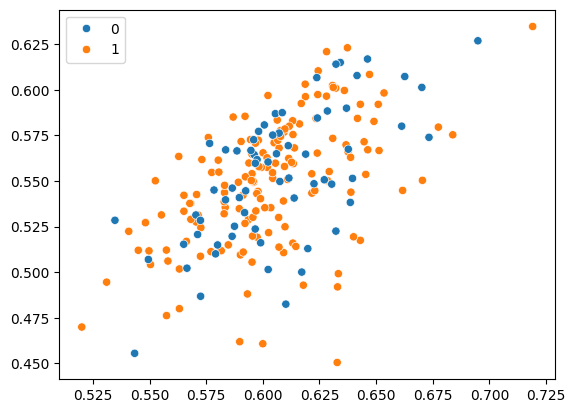

In [32]:
sns.scatterplot(
    x=np.array(graph_connectivity)[:, 1],
    y=np.array(graph_connectivity)[:, 0],
    hue=y
)

### Classificação

In [37]:
# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_train, X_test, y_train, y_test = train_test_split(graph_connectivity, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)

In [138]:
optimized_params = {'C': 1, 'coef0': 0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}

classifier = SVC(class_weight='balanced', **optimized_params)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
classifier.predict(X_test)

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.15      0.17        13
           1       0.68      0.74      0.71        31

    accuracy                           0.57        44
   macro avg       0.44      0.45      0.44        44
weighted avg       0.54      0.57      0.55        44



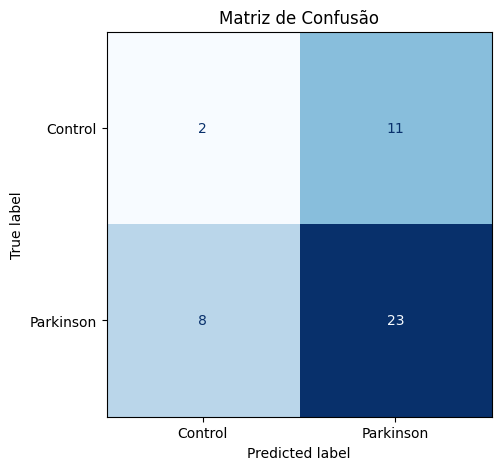

In [140]:
confusion_matrix = parkinson.utils.results.plot_confusion_matrix(y_pred, y_test, class_names=['Control','Parkinson'])

### Grid Search para otimização de hiperparâmetros

In [83]:
param_grid = [{
    'C': [1, 10],
    'gamma': ['auto', 'scale'],
    'kernel': ['poly'],
    'degree': [1, 2, 3, 4],
    'coef0': [-1, 0, 1]
}]


In [84]:
grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, scoring=['recall', 'f1'], refit=False, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END C=1, coef0=-1, degree=1, gamma=auto, kernel=poly; f1: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 2/5] END C=1, coef0=-1, degree=1, gamma=auto, kernel=poly; f1: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 3/5] END C=1, coef0=-1, degree=1, gamma=auto, kernel=poly; f1: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 4/5] END C=1, coef0=-1, degree=1, gamma=auto, kernel=poly; f1: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 5/5] END C=1, coef0=-1, degree=1, gamma=auto, kernel=poly; f1: (test=0.000) recall: (test=0.000) total time=   0.0s
[CV 1/5] END C=1, coef0=-1, degree=1, gamma=scale, kernel=poly; f1: (test=0.735) recall: (test=0.750) total time=   0.0s
[CV 2/5] END C=1, coef0=-1, degree=1, gamma=scale, kernel=poly; f1: (test=0.778) recall: (test=0.875) total time=   0.0s
[CV 3/5] END C=1, coef0=-1, degree=1, gamma=scale, kernel=poly; f1: (test=0.778) recall: (test=0

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid=[{'C': [1, 10], 'coef0': [-1, 0, 1],
                          'degree': [1, 2, 3, 4], 'gamma': ['auto', 'scale'],
                          'kernel': ['poly']}],
             refit=False, scoring=['recall', 'f1'], verbose=3)

In [86]:
pd.DataFrame(grid_search.cv_results_).sort_values(by=['rank_test_f1', 'rank_test_recall']).loc[0]['params']

{'C': 1, 'coef0': -1, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}

In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values(by=['rank_test_f1', 'rank_test_recall'], ascending=True).head()[['mean_test_recall', 'std_test_recall', 'mean_test_f1', 'std_test_f1']]

,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1
1,0.732000,0.132838,0.697166,0.083156
9,0.732000,0.132838,0.697166,0.083156
17,0.732000,0.132838,0.697166,0.083156
46,0.733333,0.210637,0.686361,0.130471
25,0.640000,0.100200,0.664287,0.064372


In [134]:
pd.DataFrame(grid_search.cv_results_).loc[1].params

{'C': 1, 'coef0': -1, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}

## Capacidade de Aprendizado do Método

Foi utilizada um ambiente de Validação Cruzada com diversos hiperparâmetros para avaliar a capacidade de aprendizado com um modelo SVM simples. SVM foi escolhido pelo tamanho do dataset e capacidade de aprendizado sobre dados tabulares não lineares.

Os hiperparâmetros incluídos são:
- Atlas: atlas, AAL3, Shen_268
- Métodos de Correlação para Construção das Matrizes: Ledoit, Pearson, Sliding Window
- Threshold para construção do grafo a partir da Matriz

Os dados são salvos em `results_dict`

In [ ]:
from parkinson.utils.correlation import (
    graphical_lasso_correlation,
    ledoit_wolf_correlation,
    pearson_correlation,
    sliding_window_correlation
)

correlation_methods_list = [
    ('ledoit', ledoit_wolf_correlation),
    ('pearson', pearson_correlation),
    ('sliding', sliding_window_correlation)
]

results_dict = {}

for atlas in tqdm(['atlas', 'AAL3', 'Shen_268']):
    results_dict[atlas] = {}
    control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, atlas)
    parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, atlas)
    for method_name, method_function in tqdm(correlation_methods_list, leave=False):
        results_dict[atlas][method_name] = {}

        parkinson_correlation_matrix = method_function(parkinson_atlas_data, return_upper_triangular=False)
        control_correlation_matrix = method_function(control_atlas_data, return_upper_triangular=False)

        correlation_matrices = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix)
        y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])
        correlation_matrices, y = parkinson.utils.data.filter_data(correlation_matrices, y)

        for threshold in tqdm(np.arange(0.04, 0.3, 0.01), leave=False):
            

            connectivity_graphs = [
                get_sparse_adjacency_matrix(matrix, threshold=threshold) 
                for matrix in correlation_matrices
            ]

            graph_laplacians = [
                sp.sparse.csgraph.laplacian(matrix, normed=True)
                for matrix in connectivity_graphs
            ]

            graph_connectivity = [
                sp.sparse.linalg.eigs(laplacian, which='SR', k=5)[0][1:6].real 
                for laplacian in graph_laplacians
            ]

            classifier = SVC(class_weight='balanced')
            score = np.mean(cross_val_score(classifier, X=graph_connectivity, y=y, cv=5))

            results_dict[atlas][method_name][threshold] = score

In [42]:
pd.DataFrame(results_dict['AAL3'])

,ledoit,pearson,sliding
0.04,0.570825,0.465539,0.584567
0.05,0.548203,0.566490,0.570613
0.06,0.507188,0.534038,0.575264
0.07,0.570930,0.529915,0.501797
0.08,0.557188,0.492812,0.502008
0.09,0.584672,0.529387,0.511628
0.10,0.561945,0.525159,0.470296
0.11,0.538901,0.570825,0.534355
0.12,0.525370,0.589006,0.506871
0.13,0.524947,0.598097,0.488689


In [43]:
pd.DataFrame(results_dict['atlas'])

,ledoit,pearson,sliding
0.04,0.511416,0.493763,0.516490
0.05,0.460782,0.520402,0.442600
0.06,0.502537,0.497886,0.446723
0.07,0.497357,0.502326,0.410465
0.08,0.483510,0.479387,0.447674
0.09,0.501903,0.506554,0.525053
0.10,0.492812,0.502114,0.534249
0.11,0.506660,0.474841,0.502326
0.12,0.501903,0.506765,0.575687
0.13,0.470085,0.548203,0.465645


In [44]:
pd.DataFrame(results_dict['Shen_268'])

,ledoit,pearson,sliding
0.04,0.598309,0.579704,0.570930
0.05,0.547992,0.616596,0.561945
0.06,0.561839,0.584778,0.525793
0.07,0.525159,0.575687,0.576110
0.08,0.534672,0.571142,0.543869
0.09,0.543869,0.584989,0.566808
0.10,0.557611,0.575793,0.534884
0.11,0.521142,0.575793,0.530021
0.12,0.525370,0.571142,0.598626
0.13,0.566596,0.580233,0.571142


## Treinando uma Rede Neural

In [17]:
X_trainval, X_test, y_trainval, y_test = train_test_split(graph_connectivity, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

In [18]:
# Criando DataLoaders
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

/home/vitor/Documents/Parkinson-Diagnosis-Deeplearning/parkinson/utils/data.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X_tensor = torch.tensor(X, dtype=torch.float32)


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customMLP(input_dim=len(X_train[0]), hidden_dim=4, output_dim=2)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

out = parkinson.utils.train.train(
    model=model,
    train_loader=train_loader, 
    val_loader=val_loader, 
    class_weights=class_weights, 
    device=device, 
    num_epochs=N_EPOCHS, 
    patience=PATIENCE,
    lr=LR/100,
    path="../weights/4_laplacian"
)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

train-loss: 0.8768  train-acc: 0.3053 | val-loss: 0.8769  val-acc: 0.2955:  10%|█         | 20/200 [00:08<01:16,  2.37it/s]

Early stopping at epoch 21


In [38]:
metrics = parkinson.utils.train.evaluate(model, test_loader, device)

/home/vitor/miniforge3/envs/parkinson/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Acurácia       F1  Precisão   Recall
 0.295455 0.134769  0.087293 0.295455


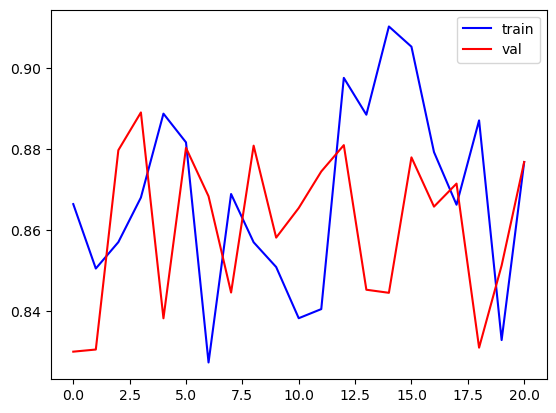

In [39]:
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'],out['val_loss'])

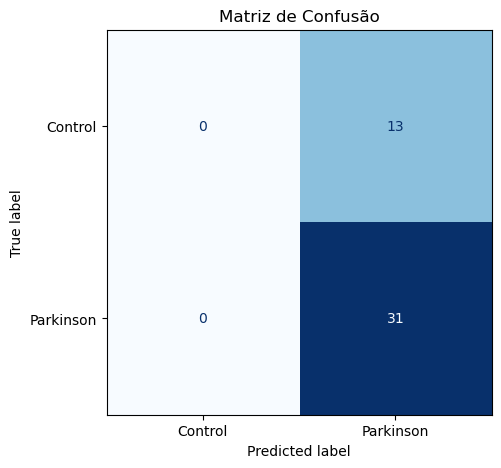

In [652]:
confusion_matrix = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson'])